# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor

# Functions definition

In [2]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions
from Fonctions import get_wavg_budget_df
from Fonctions import wavg 
from Fonctions import plotlines_Xdf
from Fonctions import plotlines_1df
from Fonctions import Deltas_Lambda

# Settings

In [44]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_official = '/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
variable = 'LW'
variables = ['rlut']

In [40]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
path_file_npy = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy'


In [41]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

In [42]:
nb_p_select = ['p860', 'p861', 'p862', 'p864', 'p865', 'p866', 'p867', 'p868', 'p869', 
                    'p870', 'p871', 'p872', 'p873','p874', 'p875', 'p876', 'p877', 'p878', 'p879',
                    'p880', 'p881', 'p882', 'p883']
len(nb_p_select)

23

# Functions

In [7]:
def get_3D_tas_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    
    return tas

In [8]:
def get_3D_LW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    LW = df['rlut']
    
    return LW

In [9]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [10]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsdt'] - df['rsut']
    
    return SW

# EOF PPE

In [45]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_LW_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_LW_xarr(path, filename, variables)

In [46]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_LW_xarr(path, filename, variables)

In [47]:
#amip['official'] = official_amip
amip['p1'] = p1_amip
amip['p1']

<xarray.DataArray 'rlut' (lat: 128, lon: 256)>
dask.array<mean_agg-aggregate, shape=(128, 256), dtype=float32, chunksize=(128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Attributes:
    long_name:           TOA Outgoing Longwave Radiation
    units:               W m-2
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       toa_outgoing_longwave_flux
    description:         at the top of the atmosphere (to be compared with sa...
    positive:            up
    history:             none
    cell_measures:       area: areacella

In [48]:
amip_list=[]

amip_list.append(amip['p1'])

for nb_p in nb_p_list :
    tmp = amip[str(nb_p)]
    amip_list.append(tmp) 

In [49]:
# essaie Aurélien 
matrix = xr.concat(amip_list, dim = 'time')
matrix

<xarray.DataArray 'rlut' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time
Attributes:
    long_name:           TOA Outgoing Longwave Radiation
    units:               W m-2
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       toa_outgoing_longwave_flux
    description:         at the top of the atmosphere (to be compared with sa...
    positive:            up
    history:             none
    cell_measures:       area: areacella

### EOF analysis

In [68]:
# Get the weights
W_eof_3D = np.load(path_file_npy+'/W_eof_3D_'+variable+'.npy')
#W_eof_3D

In [69]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [70]:
anom_w = (anom*W_eof_3D)
anom_w

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [71]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

eof = solver.eofsAsCovariance(neofs=100, pcscaling=1)
pc = solver.pcs(npcs=5, pcscaling=1)

# Get data selection

In [50]:
filename='*_amip_*.nc'
amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_LW_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])

In [51]:
amip_select_list=[]

for p in nb_p_select :
    tmp_select = amip_select[str(p)]
    amip_select_list.append(tmp_select)

In [52]:
matrix_select = xr.concat(amip_select_list, dim = 'time')
matrix_select

<xarray.DataArray 'rlut' (time: 23, lat: 128, lon: 256)>
dask.array<concatenate, shape=(23, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time
Attributes:
    long_name:           TOA Outgoing Longwave Radiation
    units:               W m-2
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       toa_outgoing_longwave_flux
    description:         at the top of the atmosphere (to be compared with sa...
    positive:            up
    history:             none
    cell_measures:       area: areacella

### Map selection mean and obs

In [53]:
mean_select = matrix_select.mean(axis=0)
mean_select

<xarray.DataArray 'rlut' (lat: 128, lon: 256)>
dask.array<mean_agg-aggregate, shape=(128, 256), dtype=float32, chunksize=(128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 ...
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [22]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/regrid_CNRM/'
filename = 'pr_mon_mean_197901-198112_regrid.nc'
variable_obs = 'pr'

In [57]:
path_observation = '/data/scratch/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'
variable_obs = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']

In [58]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [59]:
path = path_observation
variables = variable_obs
df_obs = load_monthly_clim(path, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [25]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.38347158 0.37245688 ... 0.503336 0.5036048

In [60]:
df_obs[variable] =  df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    LW               (lat, lon) float32 142.8201 142.8201 ... 194.14125

In [61]:
diff = mean_select - obs
diff

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
    height           float64 ...
Data variables:
    toa_sw_all_mon   (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
    toa_lw_all_mon   (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
    toa_net_all_mon  (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
    LW               (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>

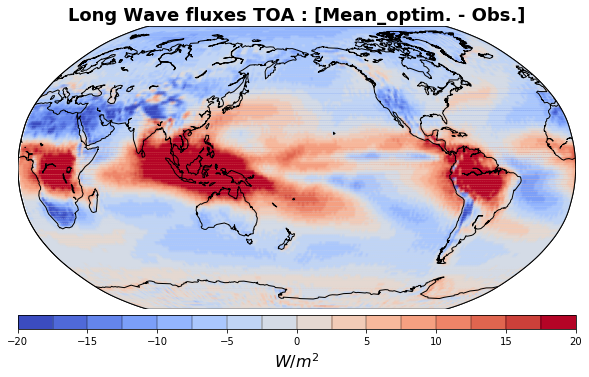

In [65]:
data = diff
lat = data['lat'][:]
lon = data['lon'][:]

fig = plt.figure(figsize=(10, 10))
ax=plt.gca()

ax.set_title('Long Wave fluxes TOA : [Mean_optim. - Obs.]', fontsize=18, fontweight = 'bold')

m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
x, y = m(*np.meshgrid(lon,lat))


cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

m.pcolormesh(x,y,data[variable],shading='gouraud',cmap=cmap)
cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
cbar.set_label('$W/m^2$', size = 16, style = 'italic')

m.drawcoastlines()
m.drawmapboundary()
plt.clim(-20, 20)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/Mean_optim_obs_"+variable, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Weightning before projection

In [75]:
anom_select = matrix_select - mean #_select
anom_select

<xarray.DataArray 'pr' (time: 23, lat: 128, lon: 256)>
dask.array<sub, shape=(23, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [76]:
anom_select_w = (anom_select*W_eof_3D)
anom_select_w

<xarray.DataArray 'pr' (time: 23, lat: 128, lon: 256)>
dask.array<mul, shape=(23, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

# Trouver U_avg of the selection and save

In [77]:
cpt=0
for i in nb_p_select :
    X = anom_select_w[cpt,:,:]
    U_avg = solver.projectField(X, neofs=5, weighted=False, eofscaling=1)
    cpt+=1
    
    # Save the U_avg
    np.save(path_file_npy+'/U_'+i+'_'+variable+'.npy', U_avg)

In [78]:
U_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([-1.22678526, -1.00573293,  1.3077143 ,  0.96654739, -1.68686959])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  pr_pseudo_pcs